# Segment trend between this year and last year

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
next_year_avg_dollar = pd.read_csv('../data/predicted/nextyear_pred_avg_dollar.csv')
next_year_consumer = pd.read_csv('../data/predicted/nextyear_pred_consumer_num.csv')
next_year_revenue = pd.read_csv('../data/predicted/nextyear_pred_revenue.csv')
next_year_transaction = pd.read_csv('../data/predicted/nextyear_pred_tran.csv')

next_year = pd.merge(next_year_avg_dollar, next_year_consumer, on='merchant_abn')
next_year = pd.merge(next_year, next_year_revenue, on='merchant_abn')
next_year = pd.merge(next_year, next_year_transaction, on='merchant_abn')
next_year.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

/var/folders/51/hrjbd3s95q7_fqgml710nj2r0000gn/T/ipykernel_71246/336218707.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  next_year = pd.merge(next_year, next_year_transaction, on='merchant_abn')


In [3]:
merchant = pd.read_csv('../data/curated/merchant/merchant_clean_segment.csv')
transaction_with_consumer_fraud = pd.read_parquet('../data/curated/transaction/transaction_wcf_after_prediction.parquet')

In [6]:
def generate_merchant_statistics(df):
    ''' 
    This function is used to generate merchant statistics
    :param df: transaction_with_consumer_fraud
    :type df: dataframe
    :return: merchant statistics dataframe
    '''
    # most frequent postcode
    merchant_postcode = df.groupby("merchant_abn")["postcode"].agg(lambda x:x.value_counts().index[0]).reset_index()

    # the number of consumer
    merchant_consumer = df.groupby("merchant_abn")["user_id"].nunique().reset_index()
    merchant_consumer = merchant_consumer.rename(columns={"user_id": "number_of_consumer"})

    # the number of transaction
    merchant_transaction = df.groupby("merchant_abn")["dollar_value"].count().reset_index()
    merchant_transaction = merchant_transaction.rename(columns={"dollar_value": "number_of_transaction"})

    # calculate average dollar value
    merchant_dollar_value = df.groupby("merchant_abn")["dollar_value"].mean().reset_index()
    merchant_dollar_value = merchant_dollar_value.rename(columns={"dollar_value": "average_dollar_value"})    

    # calculate total revenue (sum of dollar value*take_rate)
    df["take_amount"] = df["dollar_value"]*df["take_rate"]
    merchant_revenue = df.groupby("merchant_abn")["take_amount"].sum().reset_index()
    merchant_revenue = merchant_revenue.rename(columns={"take_amount": "total_revenue"})

    # calculate fraud probability
    weights = {'safe': 0.01, 'unsure': 0, 'fraud': 0.99}
    # count the number of fraud, safe and unsure
    merchant_fraud = df.groupby("merchant_abn")['consumer_fraud_probability'].value_counts().unstack(fill_value=0).reset_index()
    merchant_fraud['total_count'] = merchant_fraud[['safe', 'unsure', 'fraud']].sum(axis=1)
    merchant_fraud['composite_weight'] = (
    merchant_fraud['safe'] / merchant_fraud['total_count'] * weights['safe'] +
    merchant_fraud['unsure'] / merchant_fraud['total_count'] * weights['unsure'] +
    merchant_fraud['fraud'] / merchant_fraud['total_count'] * weights['fraud']
    )

    result_df = merchant_postcode.merge(merchant_consumer, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_transaction, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_dollar_value, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_revenue, on="merchant_abn", how="left")
    result_df = result_df.merge(merchant_fraud, on="merchant_abn", how="left")

    return result_df

In [7]:
merchant_statistics = generate_merchant_statistics(transaction_with_consumer_fraud)

In [8]:
merchant_statistics

,merchant_abn,postcode,number_of_consumer,number_of_transaction,Female,Male,Undisclosed,Male_Percentage,Female_Percentage,average_dollar_value,total_revenue,fraud,safe,unsure,total_count,composite_weight
0,10023283211,5582,3032,3261,1469,1463,329,0.448635,0.450475,215.663205,1.265900e+05,8,3225,28,3261,0.012318
1,10142254217,3494,2845,3032,1302,1420,310,0.468338,0.429420,39.035632,4.994625e+05,4,2983,45,3032,0.011144
2,10187291046,4417,335,336,147,152,37,0.452381,0.437500,118.136102,1.305924e+05,0,335,1,336,0.009970
3,10192359162,6121,383,385,169,182,34,0.472727,0.438961,462.287027,1.126617e+06,0,385,0,385,0.010000
4,10206519221,5273,7889,9605,4287,4383,935,0.456325,0.446330,37.295429,2.271131e+06,12,9555,38,9605,0.011185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,99938978285,6467,12385,17443,7855,7796,1792,0.446941,0.450324,30.000574,2.354850e+06,52,17310,81,17443,0.012875
3678,99974311662,5306,130,130,58,54,18,0.415385,0.446154,294.770198,1.214748e+05,0,130,0,130,0.010000
3679,99976658299,4346,14901,23148,10259,10583,2306,0.457189,0.443192,149.774024,2.277799e+07,22,23084,42,23148,0.010913
3680,99987905597,2127,189,191,91,87,13,0.455497,0.476440,361.841071,4.713414e+05,0,191,0,191,0.010000


In [9]:
next_year

,merchant_abn,Predicted Avg Dollar,Predicted Consumer Number,Predicted revenue,Predicted Transaction Number
0,10023.283211,215.981013,3018.559464,1.533194e+06,3484.506000
1,10142.254217,38.716586,2820.403593,4.741837e+05,3108.495600
2,10187.291046,116.774819,399.356656,1.842250e+05,349.327400
3,10192.359162,479.917474,389.869413,1.134313e+06,400.975560
4,10206.519221,37.213071,7883.547850,2.393028e+06,10578.312500
...,...,...,...,...,...
3677,99938.978286,30.161008,12535.662071,2.377972e+06,15432.722000
3678,99974.311663,306.845980,208.931115,1.649007e+05,141.536400
3679,99976.658300,150.635490,15504.729451,1.900765e+07,20520.244000
3680,99987.905598,363.406096,207.972488,4.272877e+05,181.533160


In [10]:
merchant['Merchant_ABN'] = merchant['merchant_abn']

In [11]:
next_year['merchant_abn'] = next_year['merchant_abn']*1000000

In [12]:
next_year['merchant_abn'] = next_year['merchant_abn'].astype(int)
merchant['merchant_abn'] = merchant['merchant_abn'].astype(int)

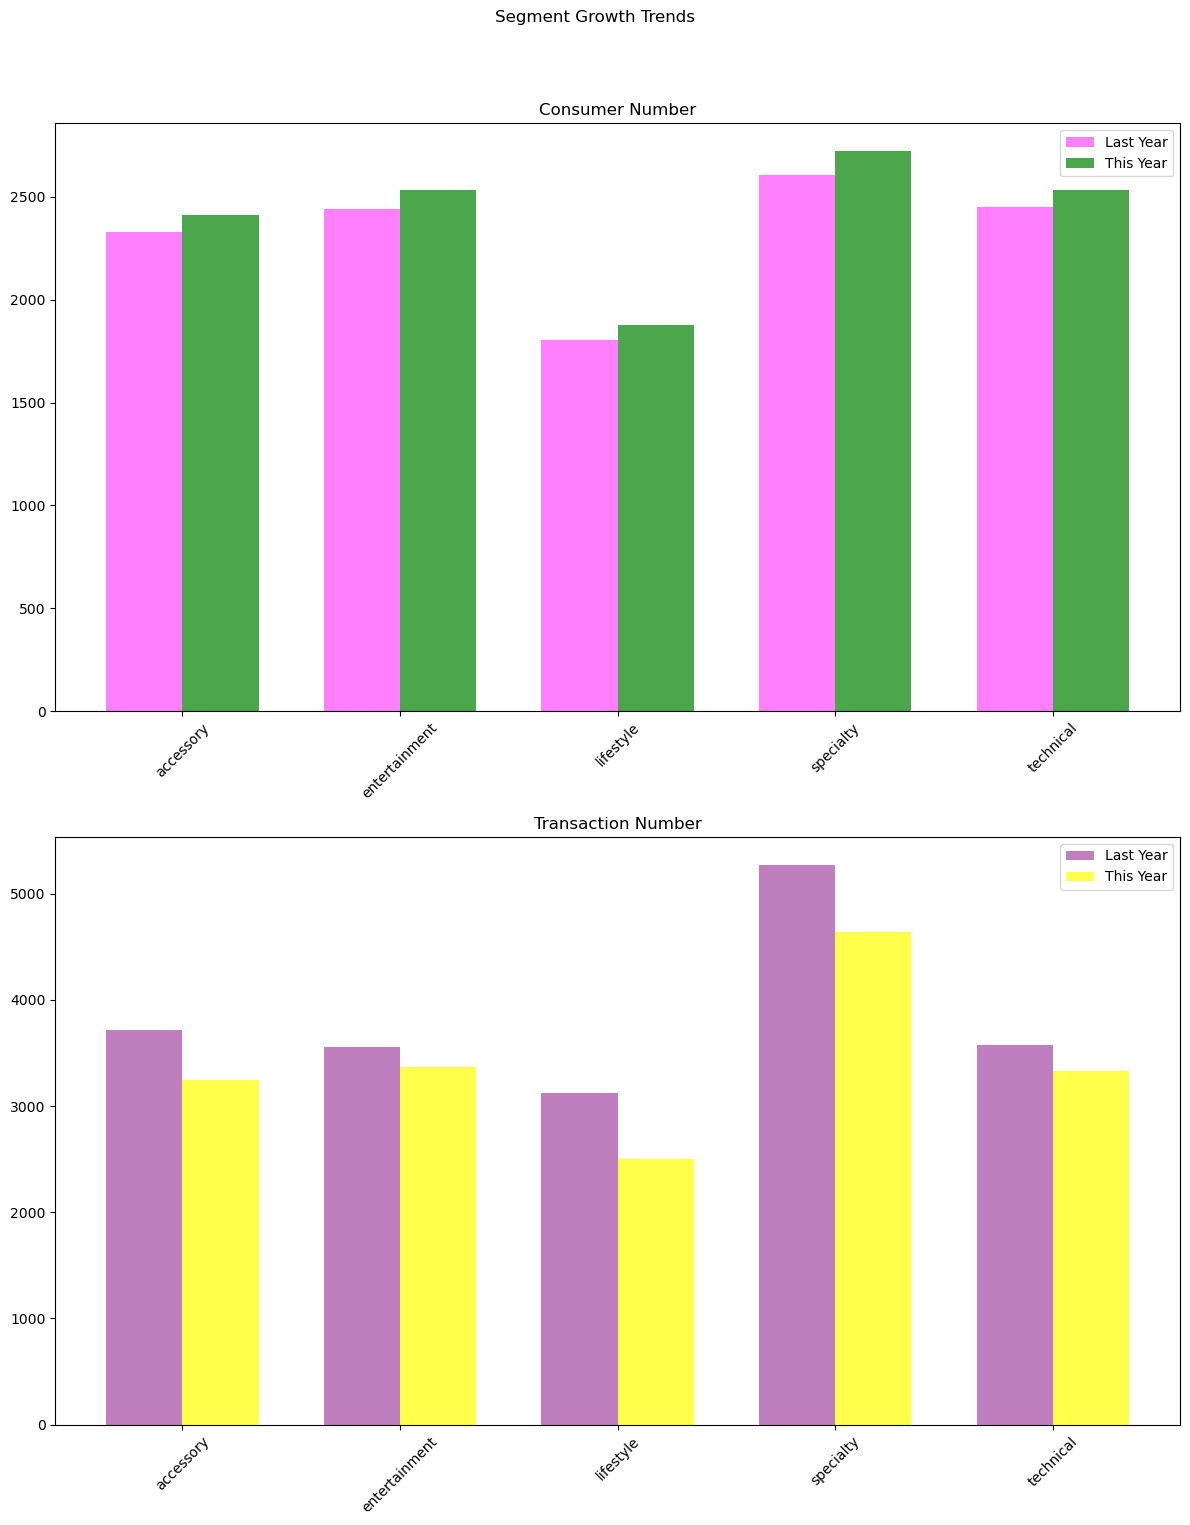

In [27]:
# combine merchant and merchant_statistics
merged_data = pd.merge(merchant, merchant_statistics, on='merchant_abn', how='left')
merged_data = pd.merge(merged_data, next_year, on='merchant_abn', how='left')
merged_data.dropna(inplace=True)

# splite by segment
segment_data_pred = merged_data.groupby('segment')[['Predicted Avg Dollar', 'Predicted Consumer Number', 'Predicted revenue', 'Predicted Transaction Number']].mean()
segment_data_this = merged_data.groupby('segment')[['average_dollar_value', 'number_of_consumer', 'total_revenue', 'number_of_transaction']].mean()

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
fig.suptitle('Segment Growth Trends')

bar_width = 0.35
index = np.arange(len(segment_data_pred.index))

# axes[0, 0].bar(index + bar_width/2, segment_data_this['average_dollar_value'], bar_width, color='cyan', alpha=0.5, label='Last Year')
# axes[0, 0].bar(index - bar_width/2, segment_data_pred['Predicted Avg Dollar'], bar_width, color='b', alpha=0.7, label='This Year')
# axes[0, 0].set_title('Avg Dollar Value')
# axes[0, 0].set_xticks(index)
# axes[0, 0].set_xticklabels(segment_data_pred.index, rotation=45)
# axes[0, 0].legend()

axes[0].bar(index - bar_width/2, segment_data_this['number_of_consumer'], bar_width, color='magenta', alpha=0.5, label='Last Year')
axes[0].bar(index + bar_width/2, segment_data_pred['Predicted Consumer Number'], bar_width, color='g', alpha=0.7, label='This Year')
axes[0].set_title('Consumer Number')
axes[0].set_xticks(index)
axes[0].set_xticklabels(segment_data_pred.index, rotation=45)
axes[0].legend()

# axes[1, 0].bar(index + bar_width/2, segment_data_this['total_revenue'], bar_width, color='orange', alpha=0.5, label='Last Year')
# axes[1, 0].bar(index - bar_width/2, segment_data_pred['Predicted revenue'], bar_width, color='r', alpha=0.7, label='This Year')
# axes[1, 0].set_title('Total Revenue')
# axes[1, 0].set_xticks(index)
# axes[1, 0].set_xticklabels(segment_data_pred.index, rotation=45)
# axes[1, 0].legend()

axes[1].bar(index - bar_width/2, segment_data_this['number_of_transaction'], bar_width, color='purple', alpha=0.5, label='Last Year')
axes[1].bar(index + bar_width/2, segment_data_pred['Predicted Transaction Number'], bar_width, color='yellow', alpha=0.7, label='This Year')
axes[1].set_title('Transaction Number')
axes[1].set_xticks(index)
axes[1].set_xticklabels(segment_data_pred.index, rotation=45)
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()